# Swan Visualization
The first cell code will read the Swan input file, and get some basic parameters for visualization.
Please execute the below code firstly, then you could generate plots separately. 

In [1]:
import numpy as np
from buoy import Buoytable

# the output directory 
opdir = 'output/'


# read INPUT file, and some basic parameter value
with open(opdir + 'INPUT') as input_file:
        for line in input_file:
            if line.startswith("$"):
                continue
            else:
                data = line.strip().split()
                
                # get the location file name
                if line.startswith("POINTS"):
                    buoy_loc_name = "%s" % (data[3].strip('\''))
                
                # get the output table name
                elif line.startswith("TABLE"):
                    buoy_table_name = "%s" % (data[3].strip('\''))
                else:
                    continue

input_file.close()

loc_list=[]

# read the location file to get locations
with open(opdir + buoy_loc_name) as point_file:
    for line in point_file:
            data = line.strip().split()
            fname_k = "%s,%s" % (data[0],data[1])
            loc_list.append(fname_k)
point_file.close()

locCount = len(loc_list)

# read the output table file to get the output variables 
with open(opdir+buoy_table_name) as buoyTable:
    lines = buoyTable.readlines()
    
    # [1:] delete first element '%' 
    outputVars = lines[4].split()[1:]
    varsDict = dict(zip(outputVars, range(len(outputVars))))
    
    varsUnit = lines[5].split()[1:]
    unitDict = dict(zip(varsUnit, range(len(varsUnit))))
    
    buoyValue = []
    for line in lines[7:]:
        buoyValue.append(line.split())



## Time Series 1D
Here you could generate time series 1D plot with output variables, including X-Windv, Y-Windv, Hsig, Dir, PkDir ...    on specific location. 
Just change the the output_var and the location index locIndex.

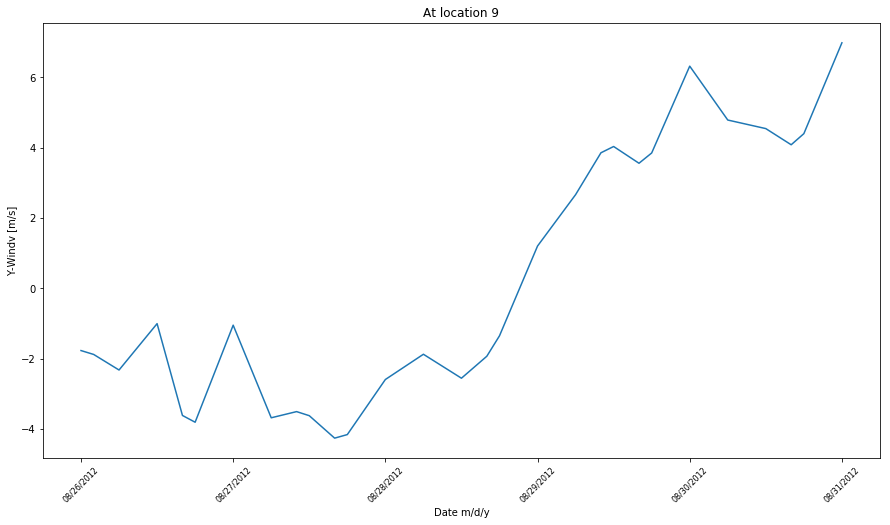

In [9]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import dates

import time
import datetime

# set output variable to show
outputVar = "Y-Windv"

# set the location 
locIndex = 9

# get the index of output variable and location 
varIndex = varsDict.get(outputVar)
unit = varsUnit[varIndex]

def singlePlot():
    plt.clf()
    plt.cla()
    plt.close()
    
    fig, ax = plt.subplots()
    
    X = []
    Y = []
    
    # get the data of output variable and location
    for line in range(locIndex - 1, len(buoyValue), locCount):
        # X is Time
        t = buoyValue[line][0]
        ymd = t[0:8]
        hms = t[9:15]
        dt = time.mktime(datetime.datetime.strptime(ymd + hms, '%Y%m%d%H%M%S').timetuple())
        X.append(int(dt))
        
        # Y is outputVar
        Y.append(buoyValue[line][int(varIndex)])
    
    dts = list(map(datetime.datetime.fromtimestamp, X))
    X = dates.date2num(dts)
    
    # generate 1D plot
    ax.plot(X,Y)
    ax.set_title("At location " + str(locIndex))
    ax.set_ylabel(outputVar+" "+unit)
    plt.xlabel("Date m/d/y")
    ax.xaxis.set_major_locator(dates.DayLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
    plt.xticks(rotation=45,fontsize=8)
    
    plt.show()    
    
    #except Exception as ex_results:
        #print ("Error: ", ex_results)
        #plt.close()

singlePlot()

## Wave Height 2D
Here you can generate wave height 2D contour for each time step.
Just change the time step parameter.

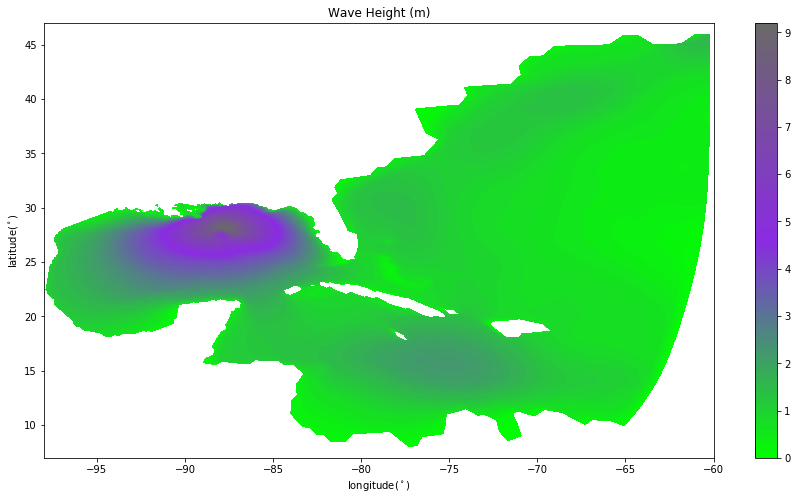

In [11]:
import matplotlib.pyplot as plt2
from matplotlib.colors import LinearSegmentedColormap

# time step
time_step = 30

# dimensions of conputational grid
x_coor = 108
y_coor = 180

# all data lines
data = []

# time_step data lines
ts_data = []

# custom color map, have to add two or two more colors 
# Here are some example, just uncomment one of below colors

colors=["#00FF00","#8A2BE2", "#696969"]
#colors=["#c29284", "#c2d0aa", "#ceddf1"]
#colors=["#7addf1", "#7a89f1", "#ce8ca3"]

cmap = LinearSegmentedColormap.from_list("", colors)

# load wave height file, and get the valid data


with open(opdir + 'hs') as hs_file:
    datalines = hs_file.readlines()
    for line in datalines:
        if line.startswith(" "):
            data.append(line)
hs_file.close()

# according to time step, and the correlated data line
time_step_line = (x_coor + 1) * (2 * time_step - 2)

# get the corralated data, write to ts_data
for idx in range(x_coor + 1):
    tmp = []

    tmp1 = data[time_step_line + idx].split()[1:]
    for i in tmp1:
        if(i == "-900."):
            i = "NaN"
        tmp.append(float(i) * 0.01)
    tmp2 = data[time_step_line + x_coor + 1 + idx].split()[1:]
    for j in tmp2:
        if(j == "-900."):
            j = "NaN"
        tmp.append(float(j) * 0.01)
    
    ts_data.append(tmp)
        
x = x_coor + 1
y = y_coor + 1

# load the longtitude and latitude of computational grid 
xy_grid = np.loadtxt(opdir+'b02.xy')
longitude = xy_grid[0:x]
for i in range(x):
    for j in range(y):
        if(longitude[i][j]==(-999.0000000000)):
            longitude[i][j]= "NaN"
latitude = xy_grid[x:2*x]
for i in range(x):
    for j in range(y):
        if(latitude[i][j]==(-999.0000000000)):
            latitude[i][j]= "NaN"

# generate contour plot 
plt2.contourf(longitude, latitude, ts_data, 100, cmap = cmap)
plt2.colorbar()
plt2.title("Wave Height (m)")
plt2.ylabel("latitude($^\circ$)")
plt2.xlabel("longitude($^\circ$)")
plt2.xlim(-98,-60)
plt2.ylim(7,47)
#plt2.show()
